In [1]:
import sys
import copy
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
from mods import prep, plotter
from scipy import optimize
%matplotlib inline
%load_ext autoreload

sys.path.append('./ligbind/')
import ligbind

In [2]:
#vary all Wym model parameters
#variance weighted by y-value (not y squared)
def lnlik(allfit,data,ligs):
    datac = np.concatenate(data)
    modparms = allfit[0:4]
    rtots = allfit[4:-1]
    f = allfit[-1]
    model = ligbind.models.wymfunc(modparms,ligs,rtots)
    invsig2 = 1.0/np.square(f * np.sqrt(model))
    return -0.5*(np.sum((datac-model)**2*invsig2 - np.log(invsig2)))

In [3]:
#uniform prior based on bounds
def lnpri(allfit,bounds):
    assert len(bounds) == len(allfit)
    if all([bounds[i][0] <= allfit[i] <= bounds[i][1] for i in range(len(bounds))]) is True:
        return 0.0
    else:
        return -np.inf

In [4]:
def lnprob(allfit,bounds,data,ligs):
    lp = lnpri(allfit,bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlik(allfit,data,ligs)

In [5]:
bnds_plock = ((4.6, 4.6),
        (5.3, 5.3),
        (0.34, 0.34),
        (530.0, 530.0),
        (5.6999999999999996e-05, 0.0057),
        (0.00010200000000000001, 0.0102),
        (0.000218, 0.0218),
        (0.000285, 0.0285),
        (0.000548, 0.054799999999999995),
        (0.00106, 0.106),
        (0.0001, 0.1))

In [6]:
bnds_allfree = ((0.001, 1000.),
        (0.001, 100.),
        (0.01, 10.),
        (100., 10000.),
        (5.6999999999999996e-05, 0.100000000000000),
        (0.00010200000000000001, 0.200000000000000),
        (0.00021800000000000001, 0.5),
        (0.00028499999999999999, 0.500000000000000),
        (0.00054799999999999998, 0.90),
        (0.00106, 0.906),
        (0.0001, 0.1))

In [7]:
guess = np.array([4.60,
                  5.30,
                  3.40e-01,
                  5.30e+02,
                  5.70e-04,
                  1.02e-03,
                  2.18e-03,
                  2.85e-03,
                  5.48e-03,
                  1.06e-02,
                  0.02])

In [8]:
nll = lambda *args: -lnlik(*args)

In [9]:
WT_08_lbl, WT_08_rtot, WT_08_lig, WT_08_sat = prep.datprep('data/EGFR_WT_08_Sat.csv','Data/EGFR_WT_08_Rtot.csv')

hootie hoo! the indices match!


In [10]:
nll_res = optimize.minimize(nll,guess,bounds=bnds_plock,args=(WT_08_sat,WT_08_lig))

In [11]:
nll_res.x

array([  4.60000000e+00,   5.30000000e+00,   3.40000000e-01,
         5.30000000e+02,   1.15430739e-03,   2.45394313e-03,
         4.16832735e-03,   3.14048777e-03,   1.25393187e-02,
         2.02417629e-02,   3.29523403e-02])

In [12]:
mlfit = nll_res.x

In [13]:
cellct = np.array([24.,43.,92.,120.,231.,447.])

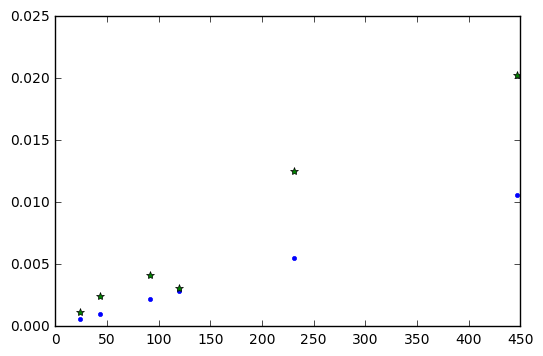

In [14]:
plt.plot(cellct,guess[4:-1],'.')
plt.plot(cellct,mlfit[4:-1],'*')

In [15]:
mlfit[4:-1]/guess[4:-1]

array([ 2.02510068,  2.4058266 ,  1.91207677,  1.10192553,  2.28819684,
        1.90960028])

In [32]:
mlfit[4:-1]
upperb = mlfit[4:-1]*3.

In [33]:
lowerb = guess[4:-1]*0.5

In [34]:
tuple(i for i in zip(lowerb,upperb))

((0.00028499999999999999, 0.0034629221565530745),
 (0.00051000000000000004, 0.0073618293826193948),
 (0.00109, 0.012504982062515015),
 (0.0014250000000000001, 0.009421463307390637),
 (0.0027399999999999998, 0.037617956020509907),
 (0.0053, 0.060725288780766246))

In [31]:
upperb

array([ 0.00230861,  0.00490789,  0.00833665,  0.00628098,  0.02507864,
        0.04048353])

In [57]:
np.random.normal(1.,0.5)*mlfit

array([  7.42170246e+00,   8.55109197e+00,   5.48560617e-01,
         8.55109197e+02,   1.86237521e-03,   3.95922516e-03,
         6.72523596e-03,   5.06690561e-03,   2.02311070e-02,
         3.26583352e-02,   5.31657533e-02])

In [31]:
mlfit.size

11

In [32]:
ndim, nwalkers = 11, 100

In [66]:
pos = [np.random.normal(1.,0.1)*mlfit for i in range(nwalkers)]

In [189]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(bnds_allfree,WT_08_sat,WT_08_lig))

In [190]:
sampler.run_mcmc(pos,5000)

(array([[  2.26017923e+01,   4.83030263e+00,   5.65534063e-01, ...,
           7.65000063e-01,   6.25748728e-01,   3.76107019e-02],
        [  6.06887112e+01,   5.03988734e+00,   5.73270325e-01, ...,
           8.16289155e-01,   8.91861293e-01,   4.03965992e-02],
        [  3.12377757e+01,   5.49567658e+00,   6.44979899e-01, ...,
           5.54634906e-01,   6.06437910e-01,   3.61468332e-02],
        ..., 
        [  4.86149762e+01,   4.87079472e+00,   4.51292182e-01, ...,
           8.28295516e-01,   7.81044761e-01,   3.64810968e-02],
        [  4.07580192e+01,   5.02728872e+00,   5.57270128e-01, ...,
           4.51986443e-01,   7.39927174e-01,   3.63836406e-02],
        [  3.72185776e+01,   5.80204291e+00,   7.50716593e-01, ...,
           8.40655991e-01,   8.08800407e-01,   3.42553050e-02]]),
 array([ 268.06324854,  269.23105561,  267.92080064,  270.20617289,
         267.77007199,  264.79075623,  273.04687781,  261.81531937,
         268.16029918,  266.22565869,  265.04474697,  26

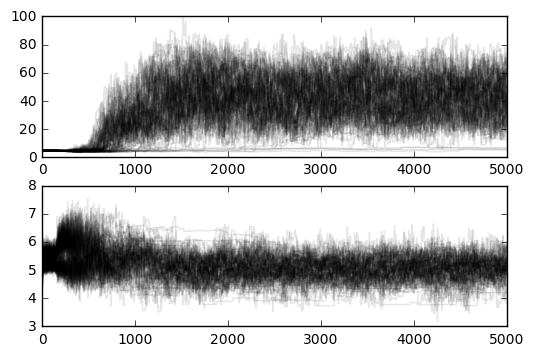

In [191]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(sampler.chain[:,:,0].T, '-', color='k', alpha=0.1);
ax1 = fig.add_subplot(212)
ax1.plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.1);

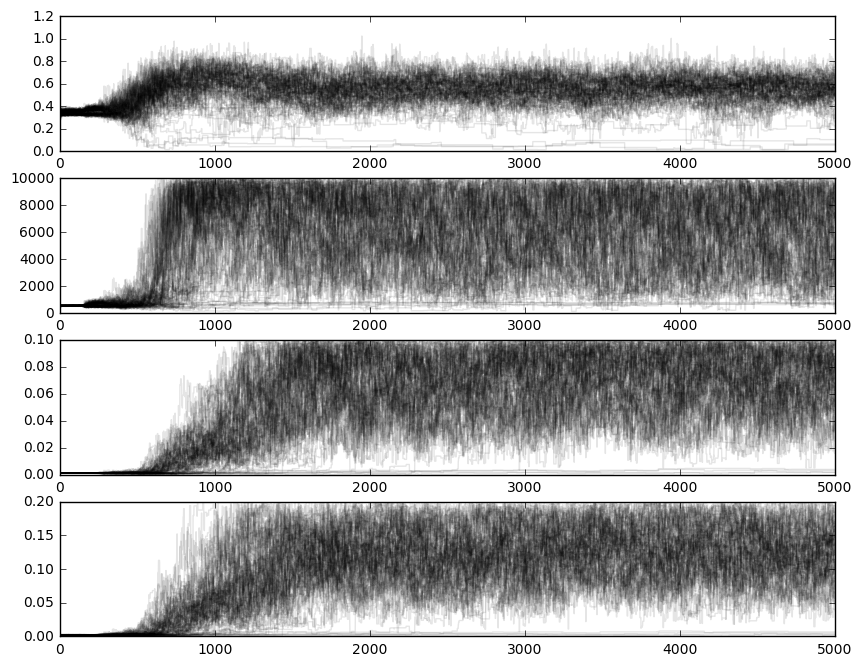

In [192]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(411)
ax1.plot(sampler.chain[:,:,2].T, '-', color='k', alpha=0.1);
ax2 = fig.add_subplot(412)
ax2.plot(sampler.chain[:,:,3].T, '-', color='k', alpha=0.1);
ax3 = fig.add_subplot(413)
ax3.plot(sampler.chain[:,:,4].T, '-', color='k', alpha=0.1);
ax3 = fig.add_subplot(414)
ax3.plot(sampler.chain[:,:,5].T, '-', color='k', alpha=0.1);

In [193]:
samples = sampler.chain[:, 1500:, :].reshape((-1, ndim))

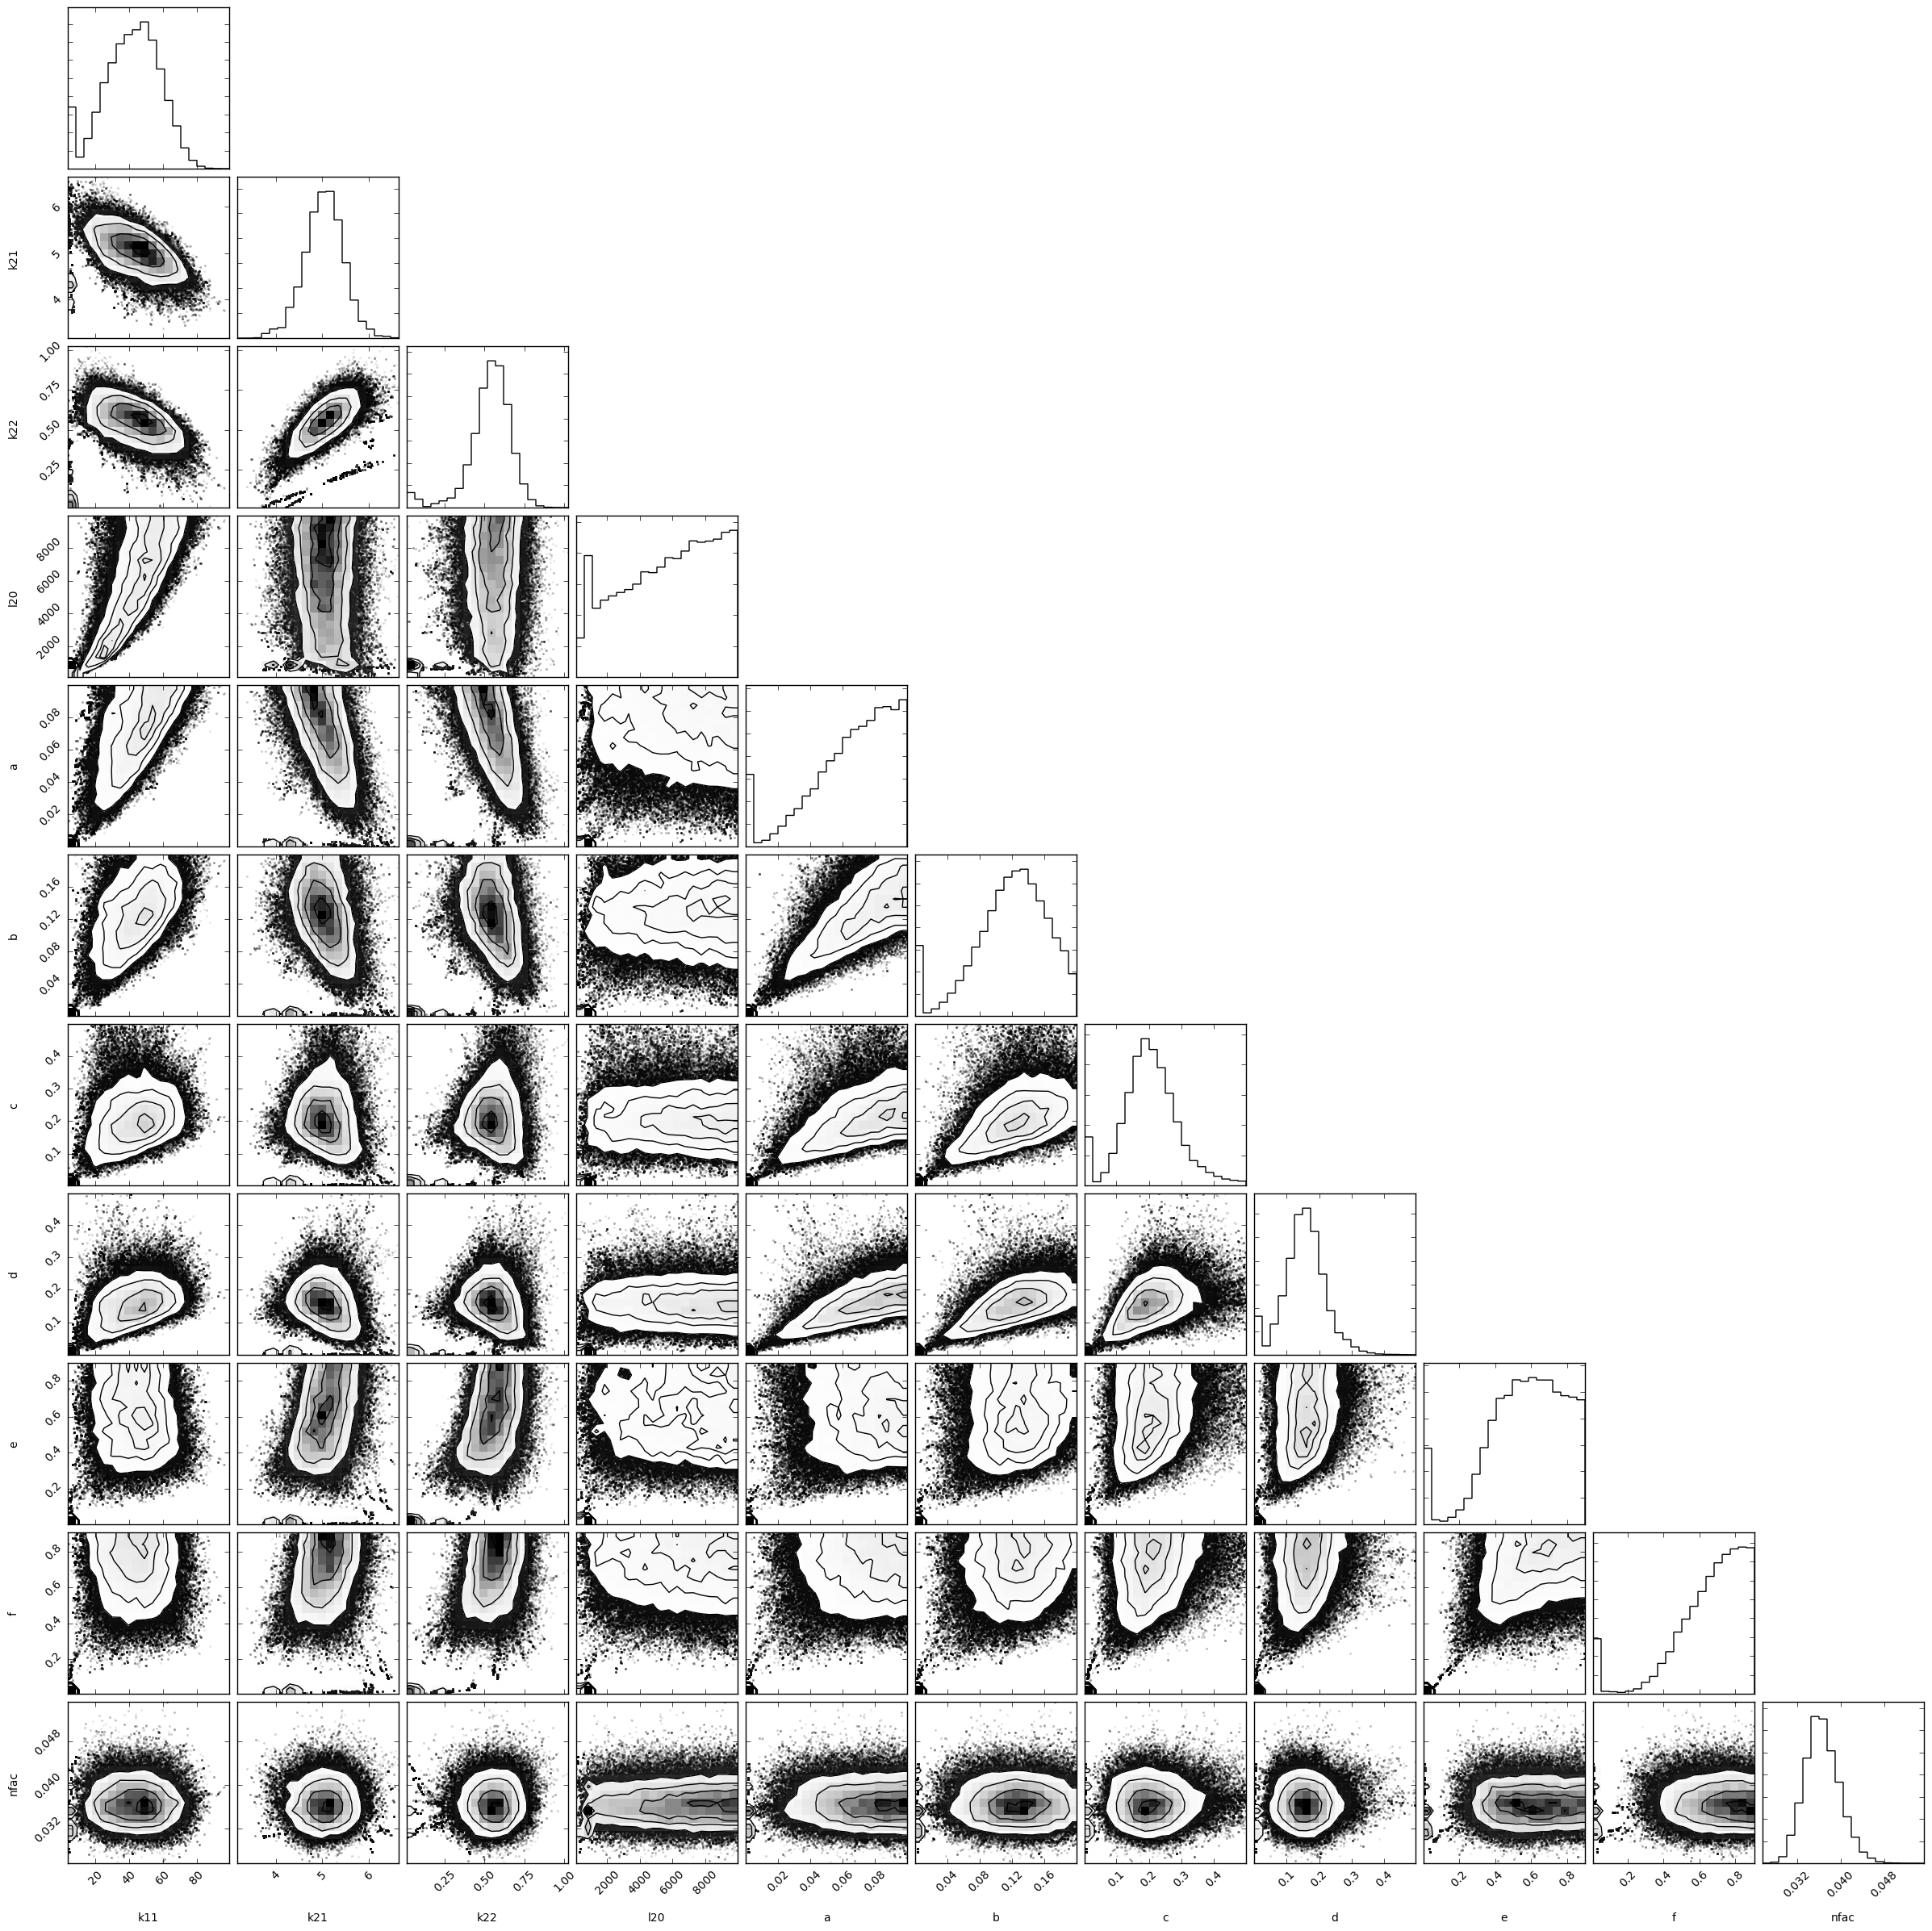

In [194]:
fig=corner.corner(samples, labels=['k11','k21','k22','l20','a','b','c','d','e','f','nfac'])

In [129]:
mcmcfits = [np.median(samples[:,i]) for i in range(ndim)]

In [80]:
mlfit

array([  4.60000000e+00,   5.30000000e+00,   3.40000000e-01,
         5.30000000e+02,   1.15430739e-03,   2.45394313e-03,
         4.16832735e-03,   3.14048777e-03,   1.25393187e-02,
         2.02417629e-02,   3.29523403e-02])

In [130]:
mcmcfits

[6.1744096354246691,
 5.5897246830878942,
 0.52927004043957471,
 1071.2349515989786,
 0.0029243811926998316,
 0.0061263212856939534,
 0.011301012588545826,
 0.0081517488066755774,
 0.040031369483484402,
 0.072935088468822101,
 0.035219451739639515]

In [131]:
mcmcfits[4:-1]

[0.0029243811926998316,
 0.0061263212856939534,
 0.011301012588545826,
 0.0081517488066755774,
 0.040031369483484402,
 0.072935088468822101]

In [96]:
hi = tuple(guess[4:-1] * 10)
hi

(0.0057000000000000002,
 0.010200000000000001,
 0.0218,
 0.028500000000000001,
 0.054799999999999995,
 0.106)

In [85]:
mlfit[4:-1]

array([ 0.00115431,  0.00245394,  0.00416833,  0.00314049,  0.01253932,
        0.02024176])

In [98]:
lo = guess[4:-1] / 10
lo

array([  5.70000000e-05,   1.02000000e-04,   2.18000000e-04,
         2.85000000e-04,   5.48000000e-04,   1.06000000e-03])

In [100]:
for i in zip(lo,hi):
    print(i)

(5.6999999999999996e-05, 0.0057000000000000002)
(0.00010200000000000001, 0.010200000000000001)
(0.00021800000000000001, 0.0218)
(0.00028499999999999999, 0.028500000000000001)
(0.00054799999999999998, 0.054799999999999995)
(0.00106, 0.106)


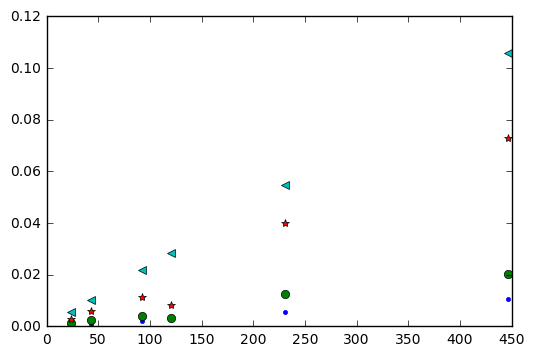

In [139]:
plt.plot(cellct,guess[4:-1],'.')
plt.plot(cellct,mlfit[4:-1],'o')
plt.plot(cellct,mcmcfits[4:-1],'*')
plt.plot(cellct,(guess[4:-1]*10),'<')

In [165]:
mcmcfits[4:-1]/mlfit[4:-1]

array([ 2.53345099,  2.4965213 ,  2.71116245,  2.59569513,  3.19246767,
        3.60319843])

In [142]:
medparms = mcmcfits[0:4]
medrtots = mcmcfits[4:-1]

(0.1, 100.0)

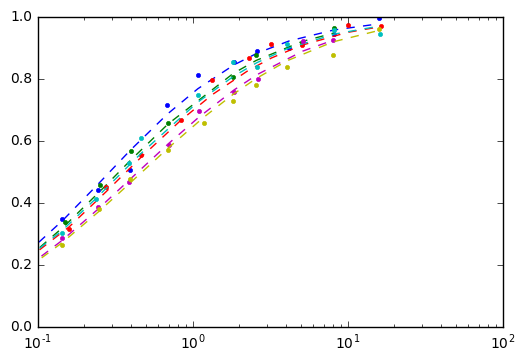

In [145]:
plotter.viewf(ligbind.models.wymfunc,medparms,WT_08_lig,WT_08_sat,medrtots)
plt.xlim(10e-2,10e1)

In [148]:
help(ligbind.models.wymfunc)

Help on function wymfunc in module ligbind.models:

wymfunc(parm, lig, rtot)
    Model function for dimerizing, single-site receptors as derived in 
    (Wyman and Gill, Binding and Linkage, 1990) and used by 
    (Macdonald and Pike, ...EGF-binding...negative cooperativity...aggregating system, 2008).
    Takes numpy array of parameters [k11,k21,k22,l20], numpy array of free ligand concentrations, 
    and total receptor concentration. Returns the fraction of receptor bound to ligand. 
    
    To generate a data set, iterate over an array of desired receptor concentrations, e.g.: 
    [wymfunc(parm,lig,i) for i in array_of_rtots]
    
    For use in curve fitting an objective function for use with scipy.optimize.least_squares 
    is readily constructed as: (wymfun(parm_guess,lig,rtot) - actual_data)



In [156]:
fit = ligbind.models.wymfunc(np.array(medparms),WT_08_lig,np.array(medrtots))
fit

array([ 0.02999668,  0.0547343 ,  0.10592525,  0.18661468,  0.25981547,
        0.3418845 ,  0.45919445,  0.56897934,  0.68648636,  0.76815534,
        0.84513494,  0.88346226,  0.92246821,  0.95759302,  0.97778996,
        0.02931012,  0.05484336,  0.10143563,  0.18373292,  0.24643434,
        0.32619148,  0.43817739,  0.53784766,  0.65453127,  0.81780586,
        0.85954378,  0.92040224,  0.94829095,  0.03417359,  0.12551733,
        0.17684662,  0.32287465,  0.43560762,  0.54835452,  0.66615625,
        0.7494979 ,  0.82785886,  0.86742388,  0.90878831,  0.95007054,
        0.96840875,  0.06756214,  0.12901207,  0.18171255,  0.30906604,
        0.41392183,  0.52031022,  0.56072191,  0.72513504,  0.8079047 ,
        0.85228288,  0.89760834,  0.94448511,  0.97053011,  0.08273999,
        0.1523294 ,  0.21554497,  0.27770639,  0.37897753,  0.47426467,
        0.59188189,  0.67556156,  0.76437226,  0.8145188 ,  0.88929503,
        0.92467111,  0.02266206,  0.04292476,  0.07980731,  0.14

In [158]:
dat = np.concatenate(WT_08_sat)

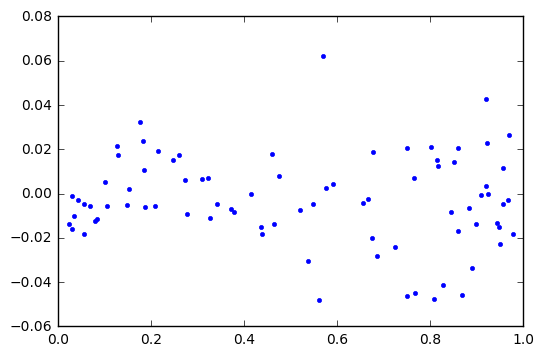

In [160]:
plt.plot(fit,(fit - dat),'.')

In [163]:
fit = ligbind.models.wymfunc(mlfit[0:4],WT_08_lig,mlfit[4:-1])
fit

array([ 0.02919676,  0.05339199,  0.10379309,  0.18412233,  0.25787841,
        0.34145677,  0.46217415,  0.57576903,  0.69672754,  0.77942618,
        0.85551889,  0.89249234,  0.92936476,  0.9618331 ,  0.9801581 ,
        0.02883456,  0.05406216,  0.10035383,  0.18290467,  0.24642762,
        0.32791425,  0.44327744,  0.54629911,  0.66616867,  0.82939163,
        0.86973811,  0.9272813 ,  0.95309978,  0.03392894,  0.12539331,
        0.17726025,  0.32637644,  0.44250642,  0.55858855,  0.67848532,
        0.76164547,  0.83814851,  0.8760943 ,  0.9152735 ,  0.95389062,
        0.97089809,  0.06698963,  0.12849092,  0.18164899,  0.31150079,
        0.41950487,  0.52941161,  0.57105396,  0.73814529,  0.81981652,
        0.86267655,  0.90570725,  0.94938284,  0.97327928,  0.08241708,
        0.152179  ,  0.21584166,  0.27863718,  0.38109494,  0.47724245,
        0.594853  ,  0.67756001,  0.76468359,  0.81384596,  0.88767265,
        0.92304403,  0.02248315,  0.04261671,  0.07933463,  0.14

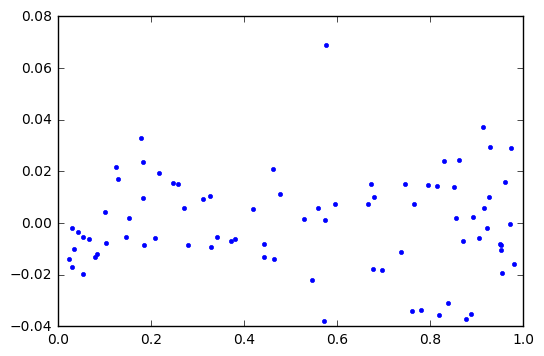

In [164]:
plt.plot(fit,(fit - dat),'.')

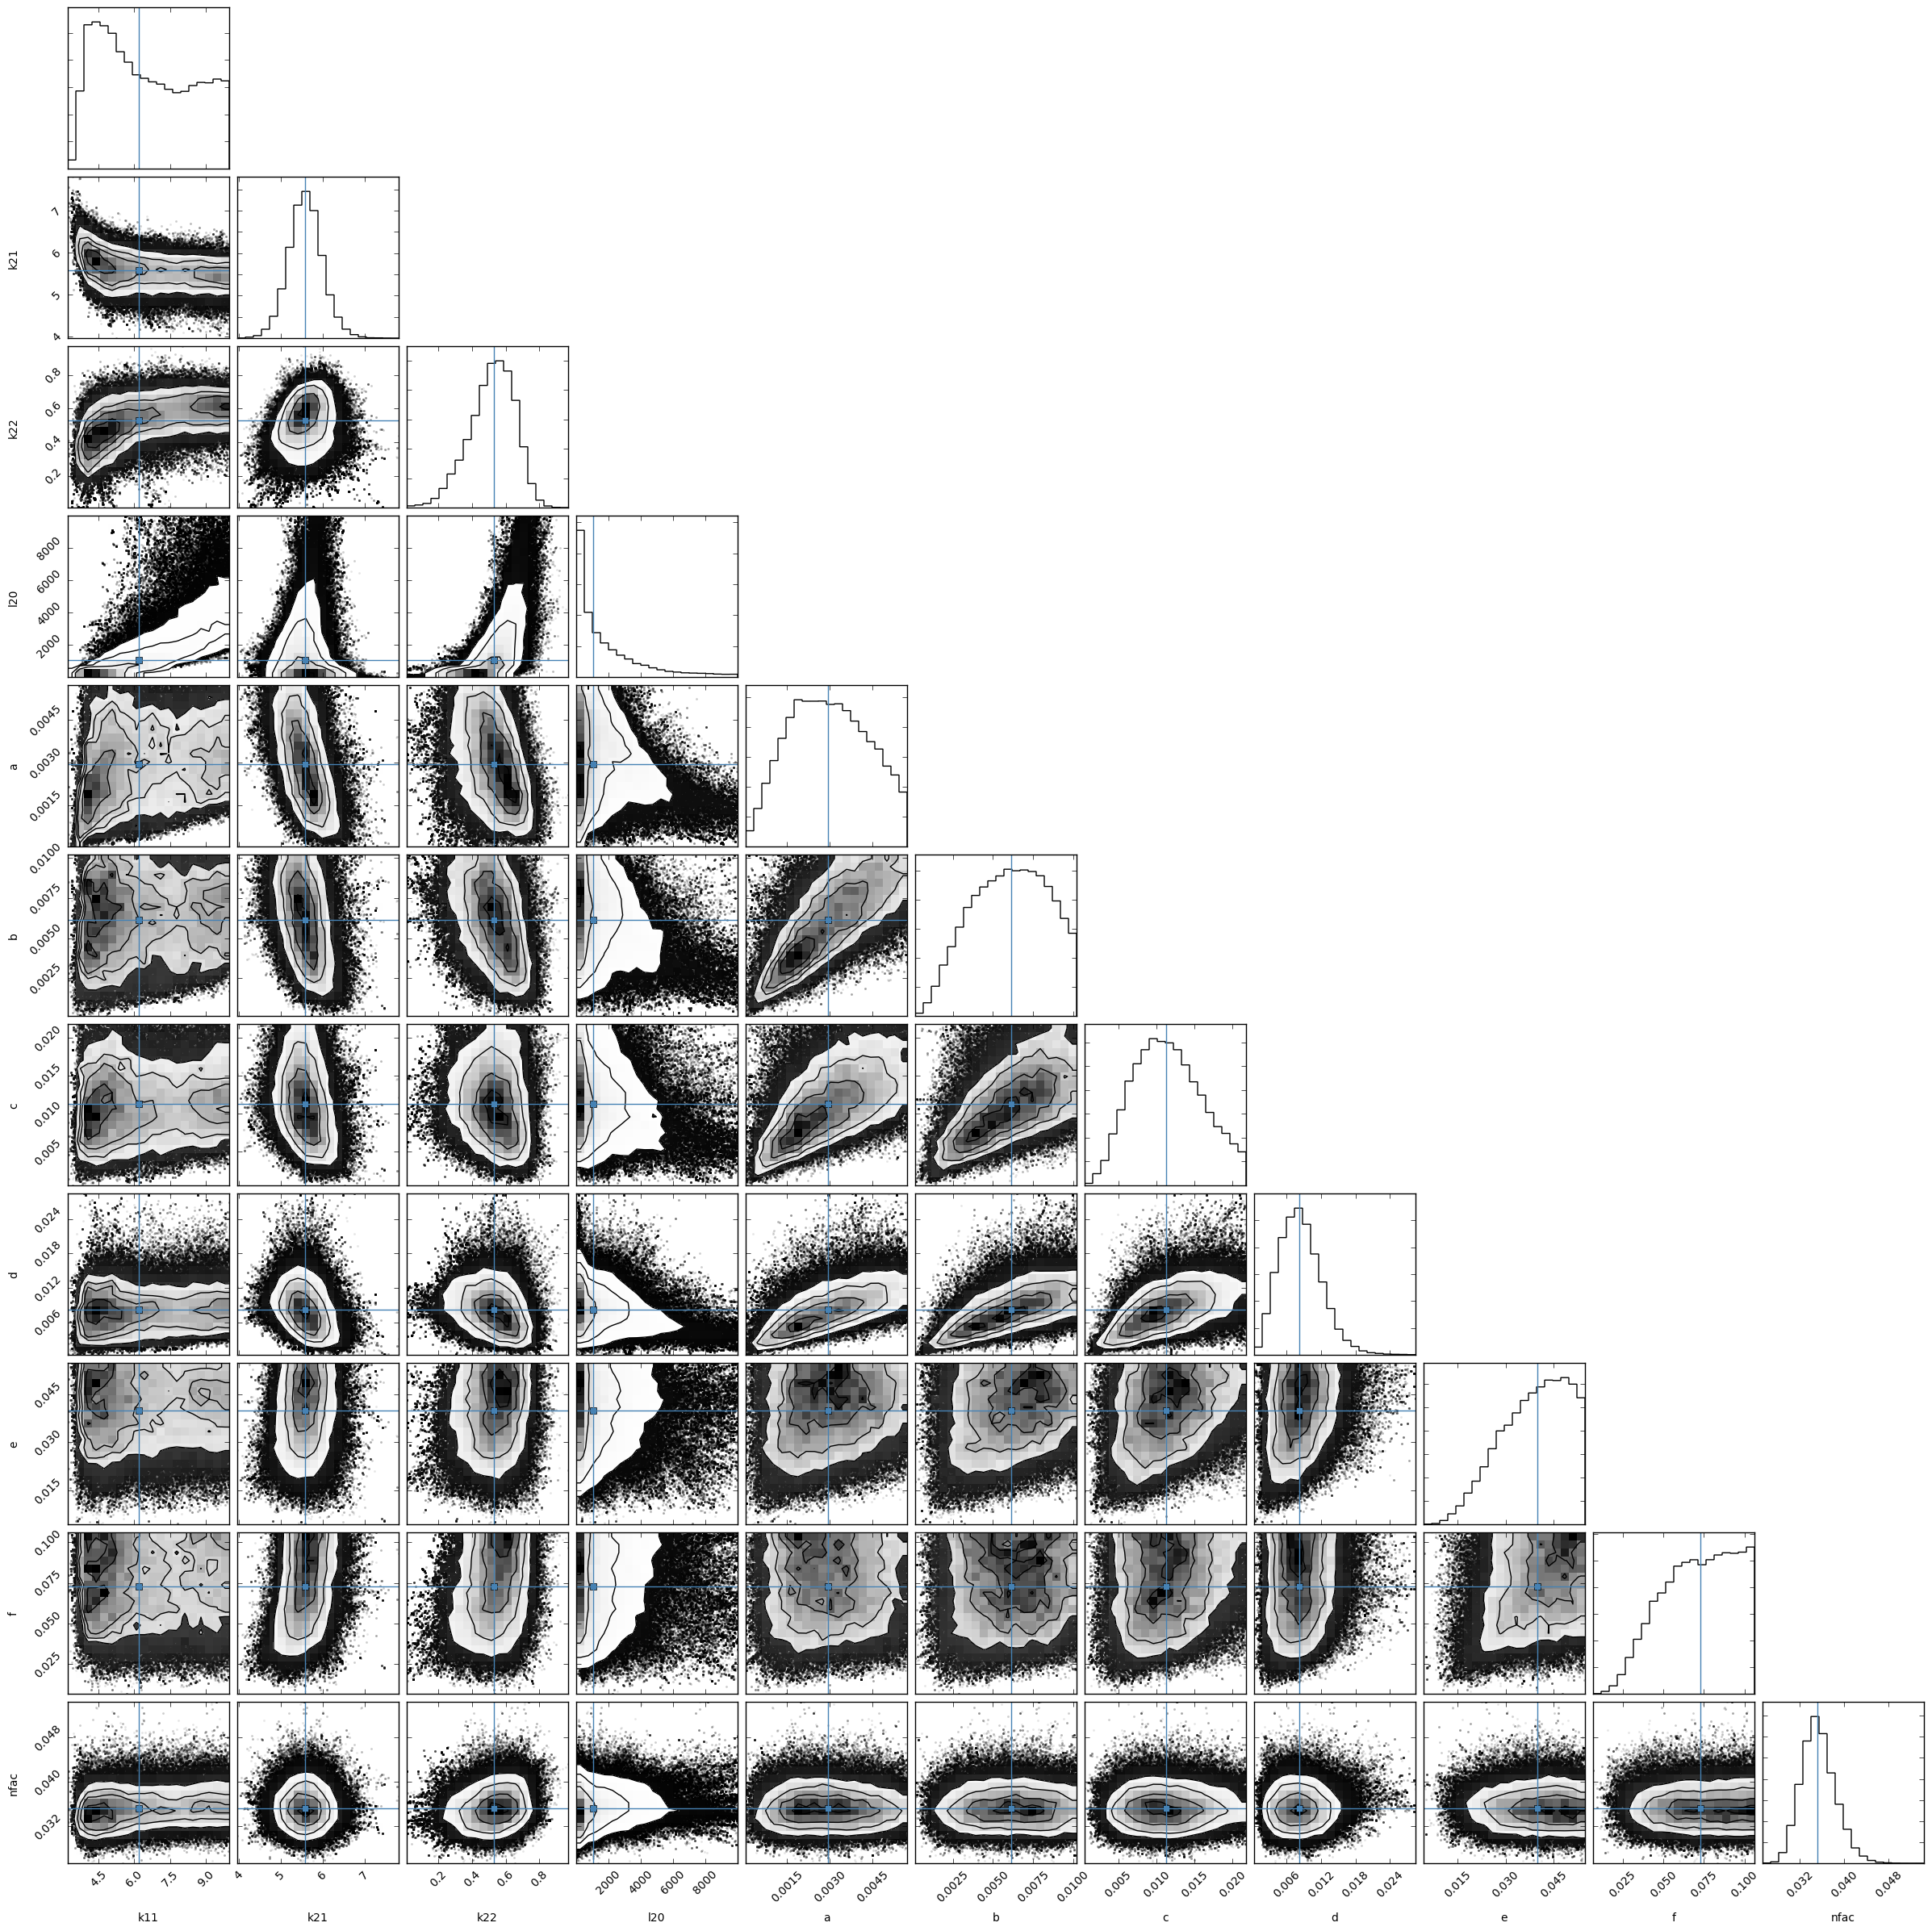

In [166]:
fig=corner.corner(samples, labels=['k11','k21','k22','l20','a','b','c','d','e','f','nfac'],truths=mcmcfits)

(0, 1000)

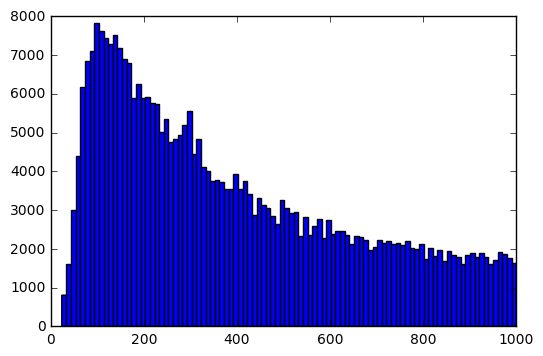

In [175]:
plt.hist(samples[:,3],bins=1000)
plt.xlim(0,1000)